# Сентимент для твиттера

[Данные](https://docs.google.com/file/d/0B04GJPshIjmPRnZManQwWEdTZjg/edit) [sentiment140](http://help.sentiment140.com/for-students) это англоязычный твиттер.

Он уже поделен на train/test. Train часть была размечена автоматически -- по наличию определенных эмоджи в тексте.

Тест часть была размечена людьми. Таким образом задача состоит в том, чтобы обучиться на шумных данных и сделать хорошие предсказания на тестовой выборке. И, конечно же, нужно превзойти бейзлайн решение.

Запустите следующую ячейку, если работаете в google colab. Это поможет быстро загрузить данные в текущий runtime.

In [12]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=0B04GJPshIjmPRnZManQwWEdTZjg' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=0B04GJPshIjmPRnZManQwWEdTZjg" -O dataset.zip && rm -rf /tmp/cookies.txt

--2018-10-13 15:53:48--  https://docs.google.com/uc?export=download&confirm=&id=0B04GJPshIjmPRnZManQwWEdTZjg
Resolving docs.google.com (docs.google.com)... 74.125.129.100, 74.125.129.138, 74.125.129.113, ...
Connecting to docs.google.com (docs.google.com)|74.125.129.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0o-70-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/q1hbpo3hm6hjcb30vp3q2nvjerc82p3o/1539439200000/12624221410083370842/*/0B04GJPshIjmPRnZManQwWEdTZjg?e=download [following]
--2018-10-13 15:53:49--  https://doc-0o-70-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/q1hbpo3hm6hjcb30vp3q2nvjerc82p3o/1539439200000/12624221410083370842/*/0B04GJPshIjmPRnZManQwWEdTZjg?e=download
Resolving doc-0o-70-docs.googleusercontent.com (doc-0o-70-docs.googleusercontent.com)... 74.125.129.132, 2607:f8b0:4001:c15::84
Connecting to doc-0o-70-docs.googleusercontent.com (doc-0o-70-docs.go

Для google colab: распаковка данных внутри runtime.

In [13]:
!unzip dataset.zip

Archive:  dataset.zip
  inflating: testdata.manual.2009.06.14.csv  
  inflating: training.1600000.processed.noemoticon.csv  


Загрузка предобученных эмбеддингов.

In [14]:
!wget http://nlp.stanford.edu/data/wordvecs/glove.twitter.27B.zip

--2018-10-13 15:54:03--  http://nlp.stanford.edu/data/wordvecs/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/wordvecs/glove.twitter.27B.zip [following]
--2018-10-13 15:54:03--  https://nlp.stanford.edu/data/wordvecs/glove.twitter.27B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408741 (1.4G) [application/zip]
Saving to: ‘glove.twitter.27B.zip.1’

glove.twitter.27B.z 100%[===================>]   1.42G  12.0MB/s    in 4m 8s   

2018-10-13 15:58:11 (5.85 MB/s) - ‘glove.twitter.27B.zip.1’ saved [1520408741/1520408741]



In [15]:
!unzip glove.twitter.27B.zip

Archive:  glove.twitter.27B.zip
replace glove.twitter.27B.100d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: glove.twitter.27B.100d.txt  y

replace glove.twitter.27B.200d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: glove.twitter.27B.200d.txt  y

replace glove.twitter.27B.25d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: glove.twitter.27B.25d.txt  
replace glove.twitter.27B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: glove.twitter.27B.50d.txt  y



In [16]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

np.random.seed(101)
%pylab inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Populating the interactive namespace from numpy and matplotlib


In [17]:
train = pd.read_csv("./training.1600000.processed.noemoticon.csv", header=None, encoding='latin-1', sep=',')
train.columns = ['sentiment', 'id', 'time', 'flag', 'username', 'text']
train = train.iloc[np.random.permutation(len(train))][:100000]
train.head()

,sentiment,id,time,flag,username,text
250977,0,1983354434,Sun May 31 12:59:58 PDT 2009,NO_QUERY,Yushimi,@Kardboard yea ugh. I don't wanna move either...
150064,0,1883616871,Fri May 22 08:50:14 PDT 2009,NO_QUERY,philwade,"Guess there's a first time for everything, my ..."
710275,0,2257860040,Sat Jun 20 15:00:38 PDT 2009,NO_QUERY,JBnVFCLover786,My cousin is going to America and it's NOT FAI...
367641,0,2049251254,Fri Jun 05 16:33:26 PDT 2009,NO_QUERY,ChelseyHart,@mitchelmusso Ahh this is my first comment to ...
575674,0,2211153017,Wed Jun 17 12:30:03 PDT 2009,NO_QUERY,GGirl33,taking care of my good friend jessica she is s...


In [18]:
train.sentiment.unique()

array([0, 4])

In [19]:
test = pd.read_csv("./testdata.manual.2009.06.14.csv", encoding='latin-1', header=None)
test.columns = ['sentiment', 'id', 'time', 'flag', 'username', 'text']
test = test.drop(test[test.sentiment == 2].index)
test.head()

,sentiment,id,time,flag,username,text
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...


In [20]:
test.sentiment.unique()

array([4, 0])

Предобработка твиттов очень важна.

In [0]:
def clean_tweet(tweet):
    tweet = tweet.lower()
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet, flags=re.MULTILINE)
    tweet = re.sub(r'[_"\-;%()|.,+&=*%]', '', tweet)
    tweet = re.sub(r'\.', ' . ', tweet)
    tweet = re.sub(r'\!', ' !', tweet)
    tweet = re.sub(r'\?', ' ?', tweet)
    tweet = re.sub(r'\,', ' ,', tweet)
    tweet = re.sub(r':', ' : ', tweet)
    tweet = re.sub(r'#', ' # ', tweet)
    #tweet = re.sub(r'@', ' @ ', tweet)
    tweet = re.sub(r'd .c .', 'd.c.', tweet)
    tweet = re.sub(r'u .s .', 'd.c.', tweet)
    tweet = re.sub(r' amp ', ' and ', tweet)
    tweet = re.sub(r'pm', ' pm ', tweet)
    tweet = re.sub(r'news', ' news ', tweet)
    tweet = re.sub(r' . . . ', ' ', tweet)
    tweet = re.sub(r' .  .  . ', ' ', tweet)
    tweet = re.sub(r' ! ! ', ' ! ', tweet)
    tweet = re.sub(r'&amp', 'and', tweet)
    return tweet

def preprocess(text, remove_stopwords=True):
    text = clean_tweet(text)
    # Convert words to lower case and split them
    text = text.lower().split()

    # Optionally, remove stop words
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        
    msg = " ".join(text)
    
    for t in text:
        if t.startswith('http'):
            msg = msg.replace(t, 'URL')
        if t.startswith('@'):
            msg = msg.replace(t, 'username')
    
    text = msg
    
    # Clean the text
    text = re.sub(r"[^a-z]", " ", text)
    text = re.sub(r"    ", " ", text) # Remove any extra spaces
    text = re.sub(r"   ", " ", text) # Remove any extra spaces
    text = re.sub(r"  ", " ", text)
    
    # Return a list of words
    return(text)

In [22]:
# Example of preprocessor work
print('**BEFORE PREPROC:**', train['text'].values[0])
print('-'*4)
print('**AFTER PREPROC:** ', preprocess(train['text'].values[0]))

**BEFORE PREPROC:** @Kardboard yea  ugh. I don't wanna move either because all my textbooks and noted are all out on the table. Sigh.
----
**AFTER PREPROC:**  username yea ugh wanna move either textbooks noted table sigh


In [23]:
train = train[['text','sentiment']]
train['text'] = list(map(preprocess, train['text']))
train[:4]

,text,sentiment
250977,username yea ugh wanna move either textbooks n...,0
150064,guess there s first time everything cars broke...,0
710275,cousin going america fair know wayyy pppl does...,0
367641,username ahh first comment youu love xxxand pl...,0


In [24]:
test['text'] = list(map(preprocess, test['text']))
test[:4]

,sentiment,id,time,flag,username,text
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,username loooooooovvvvvveee kindle dx cool fan...
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,reading kindle love lee childs good read
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,ok first assesment kindle fucking rocks
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,username love kindle i ve mine months never lo...


In [0]:
# Поменяем метки классов на более естественные:

# 0:negative, 4:positive
translate_labels = {0:0, 4:1} # 0:0 -- просто для наглядности:)
train.sentiment = [translate_labels[t] for t in train.sentiment]
test.sentiment = [translate_labels[t] for t in test.sentiment]

In [0]:
train.to_csv("preprocessed_train.csv", index=False)

# Бейзлайн

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer 
transformer = TfidfVectorizer(min_df=40, max_features=6000)
X_train = transformer.fit_transform(train.text)

In [0]:
X_test = transformer.transform(test.text)

In [0]:
y_train = train.sentiment
y_test = test.sentiment

In [30]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [0]:
# check on test part
from sklearn.metrics import f1_score, roc_auc_score 
test_pred = lr.predict_proba(X_test)

In [32]:
test_pred[:5]

array([[0.04662514, 0.95337486],
       [0.05971427, 0.94028573],
       [0.18586406, 0.81413594],
       [0.72101223, 0.27898777],
       [0.51532977, 0.48467023]])

**Для удобства возьмем в качестве метрики roc_auc**

In [33]:
roc_auc_score(y_test, test_pred[:,1])

0.8664400571180232

Это и есть то самое значение, которое необходимо превзойти.

# Tensorflow вступает в игру

In [0]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

In [35]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11711264728952129575
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11281553818
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5030056746228330867
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


**Готовим датасет**

In [0]:
tokenizer = Tokenizer(char_level=False)

In [0]:
tokenizer.fit_on_texts(train.text)
vocab_size = len(tokenizer.word_index)

In [38]:
vocab_size

61896

In [0]:
train_seqs = tokenizer.texts_to_sequences(train.text)

In [40]:
print(train_seqs[1])

[157, 312, 4, 91, 15, 258, 2008, 586, 3, 2, 61, 14, 15247, 60]


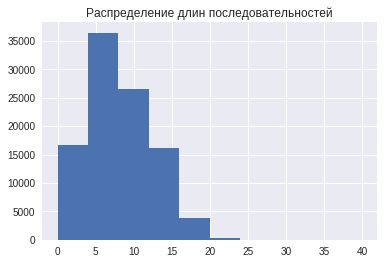

In [41]:
plt.hist([len(x) for x in train_seqs])
plt.title("Распределение длин последовательностей")
plt.show()

In [0]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [0]:
# обрезаем последовательности в начале, добиваем нулями до 20 при необходимости в конце
# тут можно все поменять на свой вкус, конечно же
padded = pad_sequences(train_seqs, maxlen=20, dtype='int32', padding='post', truncating='pre', value=0.0)

In [44]:
padded.shape

(100000, 20)

In [45]:
padded[0]

array([    1,   579,   190,    98,   510,   394, 15246,  7232,  1812,
         511,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0], dtype=int32)

#### Загружаем эмбеддинги

In [0]:
#Load GLOVE vectors
filepath_glove = 'glove.twitter.27B.100d.txt'
glove_vocab = []
glove_embd=[]
embedding_dict = {}
 
file = open(filepath_glove,'r',encoding='UTF-8')
for line in file.readlines():
    row = line.strip().split(' ')
    vocab_word = row[0]
    glove_vocab.append(vocab_word)
    embed_vector = [float(i) for i in row[1:]] # convert to list of float
    embedding_dict[vocab_word]=embed_vector
file.close()

In [47]:
len(embedding_dict)

1193515

In [48]:
len(embedding_dict['good'])

100

In [49]:
len(tokenizer.word_index)

61896

Подготовим матрицу для инициализации матрицы эмбеддингов модели.

In [0]:
# prepare embedding matrix
num_words = vocab_size+1
embedding_matrix = np.zeros((num_words, 100))
for word, i in tokenizer.word_index.items():
    embedding_vector = embedding_dict.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector


In [51]:
embedding_matrix.shape

(61897, 100)

In [52]:
embedding_matrix[3]

array([ 8.5651e-02, -1.4665e-02, -2.0531e-01, -1.3928e-01, -4.5531e-01,
        6.6880e-01, -1.5448e-01,  3.2308e-01, -5.1561e-01,  9.6171e-02,
       -3.6832e-02,  2.7032e-01, -2.8622e+00,  4.1572e-01, -2.2041e-01,
       -8.2353e-01, -7.0891e-01, -3.1757e-01, -7.4595e-01,  1.1605e+00,
       -2.9937e-04, -1.3276e-02,  5.3844e-01,  3.2003e-01,  3.9048e-01,
       -2.2494e+00, -6.9214e-01, -3.2294e-01,  6.8427e-01,  5.9943e-01,
       -9.1371e-02, -5.6070e-01, -3.1685e-01, -1.1708e-01,  1.7076e+00,
       -6.3555e-01, -4.3287e-01, -2.2535e-01,  3.5899e-01,  2.3817e-01,
       -1.8517e+00,  3.0939e-01,  4.7932e-01, -8.7741e-01, -1.8584e-01,
       -5.0600e-01,  2.8379e-02, -7.2791e-01,  8.4749e-02, -7.0856e-01,
        3.5898e-01, -2.6869e-01,  1.2857e-01,  3.7286e-01,  3.6686e-01,
       -2.9323e-01,  3.7081e-01, -6.0298e-01,  2.4040e-01, -5.0550e-01,
       -2.8867e-01, -4.5598e-01,  7.7508e-02,  1.0154e-01,  2.9443e-01,
        4.2504e-01, -2.3515e-01,  4.4486e-01, -1.5291e-01, -1.04

**Теперь Tensorflow точно вступает в игру**

Изготовим теперь удобный **tf.data.Dataset**

Более подробно можно прочитать об этом [здесь](https://towardsdatascience.com/how-to-use-dataset-in-tensorflow-c758ef9e4428) и [здесь](https://www.tensorflow.org/performance/datasets_performance)

In [0]:
tf.reset_default_graph()

In [0]:
emb_size = 100
BATCH_SIZE = 200
learning_rate = 0.001
EPOCHS = 1

In [0]:
y_train = np.array(train.sentiment)
y_train = np.expand_dims(y_train, axis=1)

In [56]:
y_train

array([[0],
       [0],
       [0],
       ...,
       [0],
       [1],
       [1]])

In [0]:
dataset = tf.data.Dataset.from_tensor_slices((padded, y_train)).shuffle(BATCH_SIZE).repeat().batch(BATCH_SIZE)

In [58]:
dataset

<BatchDataset shapes: ((?, 20), (?, 1)), types: (tf.int32, tf.int64)>

С помощью dataset API можно удобно делать итератор для имеющихся данных.

In [59]:
iterator = dataset.make_one_shot_iterator()
get_next = iterator.get_next()
print(get_next)
inputs, labels = get_next

(<tf.Tensor 'IteratorGetNext:0' shape=(?, 20) dtype=int32>, <tf.Tensor 'IteratorGetNext:1' shape=(?, 1) dtype=int64>)


**Модель**

Мы хотим сделать очень простую модель с однослойной LSTM ячейкой, которая будет пробегать по всей последовательности из слов длины 20. На каждом элементе последовательности LSTM выдает output. Мы хотим использовать output'ы для предсказания вероятности принадлежности последовательности к классу позитивных твиттов.

Матрицу эмбеддингов фиксируем, она не будет тренироваться в процессе обучения модели. 

In [0]:
embedding_mtx = tf.get_variable(name="embedding_mtx",
                                shape=embedding_matrix.shape,
                                initializer=tf.constant_initializer(embedding_matrix),
                                trainable=False)

Эта функция позволяет по индексам элементов входной последовательности (`inputs`) составить матрицу из соответствующих векторов слов из матрицы эмбеддингов (`embedding_mtx`).

In [0]:
inputs_embedded = tf.nn.embedding_lookup(params=embedding_mtx, ids=inputs)

Посмотрим на размерность полученной матрицы: [размер батча, длина последовательности, размерность эмбеддинга]

In [62]:
inputs_embedded

<tf.Tensor 'embedding_lookup/Identity:0' shape=(?, 20, 100) dtype=float32>

Однослойная LSTM сеть с размерностью выхода 100:

In [0]:
outputs, states = tf.nn.dynamic_rnn(cell=tf.nn.rnn_cell.LSTMCell(100), inputs=inputs_embedded, dtype=tf.float32)

outputs -- это выходы LSTM после каждого элемента последовательности.

In [0]:
outputs = tf.layers.flatten(outputs)

In [0]:
logits = tf.layers.dense(inputs=outputs, units=1)

In [66]:
logits

<tf.Tensor 'dense/BiasAdd:0' shape=(?, 1) dtype=float32>

In [67]:
probs = tf.nn.sigmoid(logits)
probs

<tf.Tensor 'Sigmoid:0' shape=(?, 1) dtype=float32>

In [0]:
loss = tf.nn.sigmoid_cross_entropy_with_logits(
    labels=tf.cast(labels, dtype=tf.float32),
    logits=logits,
    name='loss'
)
loss = tf.reduce_mean(loss)

In [69]:
loss

<tf.Tensor 'Mean:0' shape=() dtype=float32>

In [0]:
train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)

In [0]:
#sess.close()

In [72]:
losses = []
num_epochs = 1
num_iter_per_epoch = 3000

sess = tf.Session()
sess.run(tf.global_variables_initializer())
for i in range(num_epochs):
  print('Epoch ',i)
  aver_loss = 0.
  for j in range(num_iter_per_epoch):
    loss_cur, _ = sess.run([loss, train_op])
    aver_loss += loss_cur
    if j % 300 == 0:
      print('Loss: ', aver_loss / 300.)
      aver_loss = 0.
      
    losses.append(loss_cur)

Epoch  0
Loss:  0.002365668018658956
Loss:  0.5363485405842463
Loss:  0.5025484961271286
Loss:  0.4863923622171084
Loss:  0.47722873618205386
Loss:  0.4744500646988551
Loss:  0.46267041703065237
Loss:  0.4572047840555509
Loss:  0.44844089378913243
Loss:  0.4426309593518575


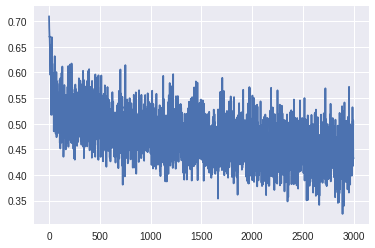

In [73]:
plt.plot(losses)

**Измеряем точность**

In [0]:
test_seqs = tokenizer.texts_to_sequences(test.text)
padded_test = pad_sequences(test_seqs, maxlen=20, dtype='int32', padding='post', truncating='pre', value=0.0)

In [0]:
test_pred = sess.run(probs, feed_dict={inputs: padded_test})

In [76]:
roc_auc_score(y_test, test_pred)

0.8739057552616875

** Мы улучшили результат TF-IDF модели, но кажется, что можно куда лучше**

# Задание

Исследуйте нейронку и опишите свои наблюдения. Зафиксируйте количество итераций обучения и меняйте параметры сети. 
Можно выбрать для исследования **любые 3 ** из предложенных вопросов.

1.   Как размер батча влияет на roc_auc?
2.   Как размерность скрытого слоя LSTM влияет на roc_auc?
3.   Что изменится, если вместо всех outputs LSTM взять только последние выходы LSTM на последнем шаге. Улучшился или ухудшился при этом roc_auc?
4.   Что изменится, если взять char эмбеддинги заместо word? Провести эксперименты, добится roc_auc > 0.5. (Это может оказаться сложным, потому можно взять одну эту задачку вместо 3х)
5.   Что изменится, если взять несколько слоев LSTM?
6.   Что изменится, если взять bidirectional LSTM?
7.   Что если обучать эмбеддинги вместе с обучением модели и не использовать инициализацию предобученными эмбеддингами? Сколько потребуется итераций обучения, чтобы достичь результата с использованием предобученных эмбеддингов?

Опишите подробно что вы делали словами и что у вас вышло.
Код тоже нужно оставить доступным для обозрения.

Получилось ли у вас улучшить результат нейронки?

# Ваш отчет здесь


In [0]:
y_train = np.array(train.sentiment)
y_train = np.expand_dims(y_train, axis=1)
#X_train, X_val, y_train, y_val = train_test_split(padded, y_train, test_size=0.05, random_state=42)

In [0]:
def runModel(batch_size=200, 
             LSTMCell_size=100, 
             use_last_output=False, 
             number_of_lstm_layers=1, 
             bidirectional=False):
  tf.reset_default_graph()
  emb_size = 100
  BATCH_SIZE = batch_size
  learning_rate = 0.001
  EPOCHS = 1

  dataset = tf.data.Dataset.from_tensor_slices((padded, y_train)).shuffle(BATCH_SIZE).repeat().batch(BATCH_SIZE)
  iterator = dataset.make_one_shot_iterator()
  get_next = iterator.get_next()
  inputs, labels = get_next
  embedding_mtx = tf.get_variable(name="embedding_mtx",
                                  shape=embedding_matrix.shape,
                                  initializer=tf.constant_initializer(embedding_matrix),
                                  trainable=False)
  inputs_embedded = tf.nn.embedding_lookup(params=embedding_mtx, ids=inputs)
  
  if bidirectional:
    lstm_fw_cell = tf.contrib.rnn.LSTMCell(LSTMCell_size)
    lstm_bw_cell = tf.contrib.rnn.LSTMCell(LSTMCell_size)
    outputs, (state_fw, state_bw) = tf.nn.bidirectional_dynamic_rnn(cell_fw=lstm_fw_cell, 
                                                      cell_bw=lstm_bw_cell, 
                                                      inputs=inputs_embedded, 
                                                      dtype=tf.float32)
  else:
    LTSM_Layer = tf.contrib.rnn.LSTMCell(LSTMCell_size)
    cell = tf.contrib.rnn.MultiRNNCell([LTSM_Layer] * number_of_lstm_layers)
    outputs, states = tf.nn.dynamic_rnn(cell=cell, inputs=inputs_embedded, dtype=tf.float32)
  
  if use_last_output:
    outputs = outputs[:, -1, :]
  else:
    outputs = tf.concat(outputs, 2)
    outputs = tf.layers.flatten(outputs)
  
  logits = tf.layers.dense(inputs=outputs, units=1)
  probs = tf.nn.sigmoid(logits)
  loss = tf.nn.sigmoid_cross_entropy_with_logits(
      labels=tf.cast(labels, dtype=tf.float32),
      logits=logits,
      name='loss'
  )
  loss = tf.reduce_mean(loss)
  train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)
  losses = []
  num_epochs = 1
  num_iter_per_epoch = 3000

  sess = tf.Session()
  sess.run(tf.global_variables_initializer())
  for i in range(num_epochs):
    aver_loss = 0.
    for j in range(1, num_iter_per_epoch+1):
      loss_cur, _ = sess.run([loss, train_op])
      aver_loss += loss_cur
      if j % 1000 == 0:
        print(f'Train loss on {j}: ', aver_loss / 1000.)
        aver_loss = 0.
      losses.append(loss_cur)
  plt.plot(losses)
  #val_pred = sess.run(probs, feed_dict={inputs: X_val})
  test_seqs = tokenizer.texts_to_sequences(test.text)
  padded_test = pad_sequences(test_seqs, maxlen=20, dtype='int32', padding='post', truncating='pre', value=0.0)
  test_pred = sess.run(probs, feed_dict={inputs: padded_test})
  #print(f'ROC_AUC val: {roc_auc_score(y_val, val_pred)}')
  print(f'ROC_AUC test: {roc_auc_score(y_test, test_pred)}')
  sess.close()

## 1

Используя батчи размером 50, алгоритм показывает лучшее качество

Batch size: 10
Train loss on 1000:  0.5548649526536464
Train loss on 2000:  0.519148217394948
Train loss on 3000:  0.5117336673140526
ROC_AUC test: 0.8857018687527162
Batch size: 20
Train loss on 1000:  0.5406885987818241
Train loss on 2000:  0.5102411876767874
Train loss on 3000:  0.5075809431523085
ROC_AUC test: 0.8901409325138139
Batch size: 50
Train loss on 1000:  0.5252079110741615
Train loss on 2000:  0.5024882786870003
Train loss on 3000:  0.48029076370596885
ROC_AUC test: 0.9003849258086547
Batch size: 100
Train loss on 1000:  0.5185293517410755
Train loss on 2000:  0.4835790066719055
Train loss on 3000:  0.46839989882707594
ROC_AUC test: 0.8785000310424039
Batch size: 200
Train loss on 1000:  0.506482783794403
Train loss on 2000:  0.4676561391353607
Train loss on 3000:  0.44533308574557307
ROC_AUC test: 0.8858260383684113
Batch size: 500
Train loss on 1000:  0.48931087511777877
Train loss on 2000:  0.4386184783577919
Train loss on 3000:  0.39570740765333173
ROC_AUC test: 0.860

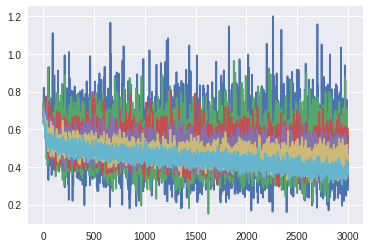

In [79]:
batch_sizes = [10,20,50,100,200,500]
for bs in batch_sizes:
  print(f'Batch size: {bs}')
  runModel(bs)

## 2

Используя размерность скрытого слоя 50, алгоритм показывает лучшее качество

LSTM_cell size: 10
Train loss on 1000:  0.5234417287409305
Train loss on 2000:  0.48608244705200193
Train loss on 3000:  0.475881578207016
ROC_AUC test: 0.8835599428819767
LSTM_cell size: 20
Train loss on 1000:  0.516969764471054
Train loss on 2000:  0.4803007063865662
Train loss on 3000:  0.468154933899641
ROC_AUC test: 0.885205190289936
LSTM_cell size: 50
Train loss on 1000:  0.5084303601980209
Train loss on 2000:  0.47137856236100195
Train loss on 3000:  0.4552524669766426
ROC_AUC test: 0.8933693425218849
LSTM_cell size: 100
Train loss on 1000:  0.5068925744593143
Train loss on 2000:  0.46603741866350173
Train loss on 3000:  0.44331345465779304
ROC_AUC test: 0.8857018687527162
LSTM_cell size: 200
Train loss on 1000:  0.5057842743992805
Train loss on 2000:  0.4639932785928249
Train loss on 3000:  0.4290410912334919
ROC_AUC test: 0.8590364437822066
LSTM_cell size: 500
Train loss on 1000:  0.5047365766465663
Train loss on 2000:  0.4599453586935997
Train loss on 3000:  0.404223181009292

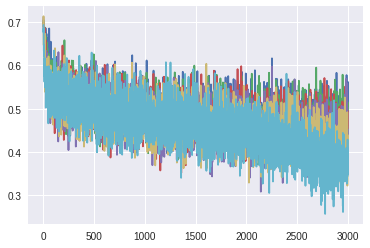

In [80]:
lstm_cell_sizes = [10,20,50,100,200,500]
for ls in lstm_cell_sizes:
  print(f'LSTM_cell size: {ls}')
  runModel(200, ls)

## 3

Используя только последний выход, алгоритм показывает лучшее качество, но не сильно лучше

Using last output
Train loss on 1000:  0.5091369857490062
Train loss on 2000:  0.47138555493950846
Train loss on 3000:  0.45304193678498267
ROC_AUC test: 0.8725709318929658


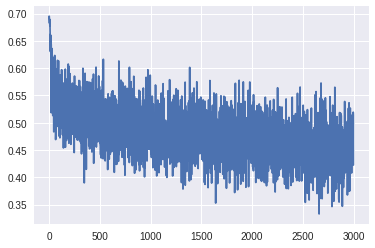

In [81]:
print('Using last output')
runModel(200, 100, True)

## 5

Используя 2 слоя LSTM, алгоритм показывает лучшее качество

Number of layers: 2
Train loss on 1000:  0.5091857289671898
Train loss on 2000:  0.470226188570261
Train loss on 3000:  0.45038342812657356
ROC_AUC test: 0.8807971689327623
Number of layers: 3
Train loss on 1000:  0.5109637332856655
Train loss on 2000:  0.4726588720083237
Train loss on 3000:  0.45355685997009276
ROC_AUC test: 0.8777550133482338


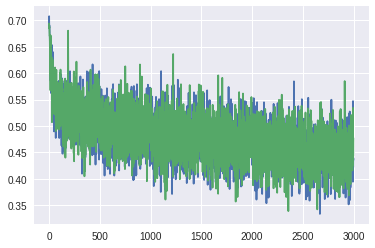

In [82]:
layers = [2,3]
for l in layers:
  print(f'Number of layers: {l}')
  runModel(200, 100, False, l)

## 6

Одностороняя LSTM показывает лучшее качество

Bidirectional
Train loss on 1000:  0.505086039096117
Train loss on 2000:  0.4619671802818775
Train loss on 3000:  0.4266072869300842
ROC_AUC test: 0.8729744831439747
Unidirectional
Train loss on 1000:  0.5060909924209118
Train loss on 2000:  0.46701347905397417
Train loss on 3000:  0.44417590215802194
ROC_AUC test: 0.8760166387285031


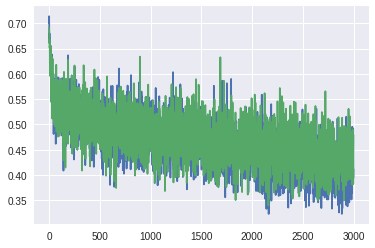

In [83]:
print('Bidirectional')
runModel(batch_size=200, 
         LSTMCell_size=100, 
         use_last_output=False, 
         number_of_lstm_layers=1, 
         bidirectional=True)
print('Unidirectional')
runModel(batch_size=200, 
         LSTMCell_size=100, 
         use_last_output=False, 
         number_of_lstm_layers=1, 
         bidirectional=False)

Построим модель с оптимальными параметрами

Best
Train loss on 1000:  0.5300684834718704
Train loss on 2000:  0.5046433309316635
Train loss on 3000:  0.48417410442233083
ROC_AUC test: 0.9055379648599988


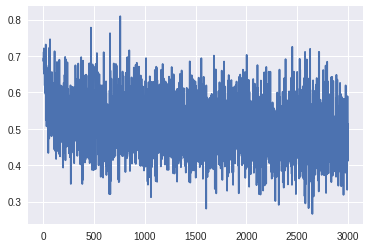

In [85]:
print('Best')
runModel(batch_size=50, 
         LSTMCell_size=100, 
         use_last_output=True, 
         number_of_lstm_layers=2)